In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from scipy.stats import ks_2samp, pearsonr, zscore

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

### Load necessary tracking data

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
pmax_array = nc_open_compile(file_years,"pmax")

tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (pmax_array >= 10**(-1)))[:,0]

In [30]:
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
#sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
#sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*100
i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
#sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3

### Plot the instantaneous and lifetime minimum cloud-top temperature stratified by extent

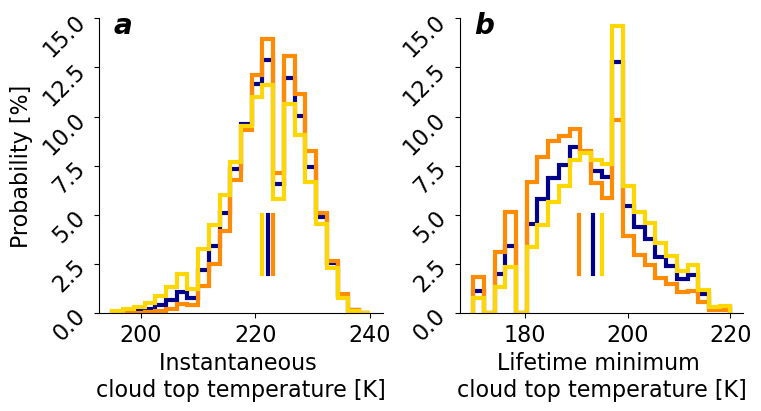

In [62]:
fig, ax = plt.subplots( nrows=1, ncols=2, figsize =(7.5, 4), constrained_layout=True )
nbin=25
lw=3
fs=16

ax[0].hist( ctt_ERAI,lw=lw,weights=np.ones_like( ctt_ERAI )/ float(len( ctt_ERAI ))*100,color='darkblue',bins=np.linspace(195,240,nbin),histtype='step' )
ax[0].plot( [np.nanmean(ctt_ERAI), np.nanmean(ctt_ERAI)],[2,5],lw=lw,color='darkblue' )

ctt_large = ctt_ERAI[rad_ERAI>=np.percentile(rad_ERAI,75)]
wgts = np.ones_like( ctt_large )/float(len( ctt_large ))*100
ax[0].hist( ctt_large,lw=lw,weights=wgts,color='darkorange',bins=np.linspace(195,240,nbin),histtype='step' )
ax[0].plot( [np.nanmean(ctt_large), np.nanmean(ctt_large)],[2,5],lw=lw,color='darkorange' )
ax[0].set_xlabel( 'Instantaneous '+
                 '\n'+ 'cloud top temperature [K]', fontsize=fs )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].text( 0.05, 0.95, 'a', weight='bold', fontsize=fs+4, style='italic', transform=ax[0].transAxes )

ctt_small = ctt_ERAI[rad_ERAI<=np.percentile(rad_ERAI,25)]
wgts = np.ones_like( ctt_small )/float(len(ctt_small))*100
ax[0].hist( ctt_small,lw=lw,weights=wgts,color='gold',bins=np.linspace(195,240,nbin),histtype='step' )
ax[0].plot( [np.nanmean(ctt_small), np.nanmean(ctt_small)],[2,5],lw=lw,color='gold' )


ax[1].hist( minctt_ERAI,lw=lw,weights=np.ones_like( minctt_ERAI )/ float(len( minctt_ERAI ))*100,color='darkblue',bins=np.linspace(170,220,nbin),histtype='step' )
ax[1].plot( [np.nanmean(minctt_ERAI), np.nanmean(minctt_ERAI)],[2,5],lw=lw,color='darkblue' )

minctt_large = minctt_ERAI[rad_ERAI>=np.percentile(rad_ERAI,75)]
wgts = np.ones_like( minctt_large )/float(len( minctt_large ))*100
ax[1].hist(minctt_large,weights=wgts,lw=lw,color='darkorange',bins=np.linspace(170,220,nbin),histtype='step')
ax[1].plot( [np.nanmean(minctt_large), np.nanmean(minctt_large)],[2,5],lw=lw,color='darkorange' )

minctt_small = minctt_ERAI[rad_ERAI<=np.percentile(rad_ERAI,25)]
wgts = np.ones_like( minctt_small )/float(len( minctt_small ))*100
ax[1].hist(minctt_small,lw=lw,weights=wgts,color='gold',bins=np.linspace(170,220,nbin),histtype='step')
ax[1].plot( [np.nanmean(minctt_small), np.nanmean(minctt_small)],[2,5],lw=lw,color='gold' )

ax[1].set_xlabel( 'Lifetime minimum '+
                 '\n'+ 'cloud top temperature [K]', fontsize=fs )
ax[1].text( 0.05, 0.95, 'b', weight='bold', fontsize=fs+4, style='italic', transform=ax[1].transAxes )

for a in ax.flatten():
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylim([0,15])

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/S7-minctt-ctt.pdf', bbox_inches='tight' )
plt.show()

### Plot lower-tropospheric saturation deficit filtered by MCS extent

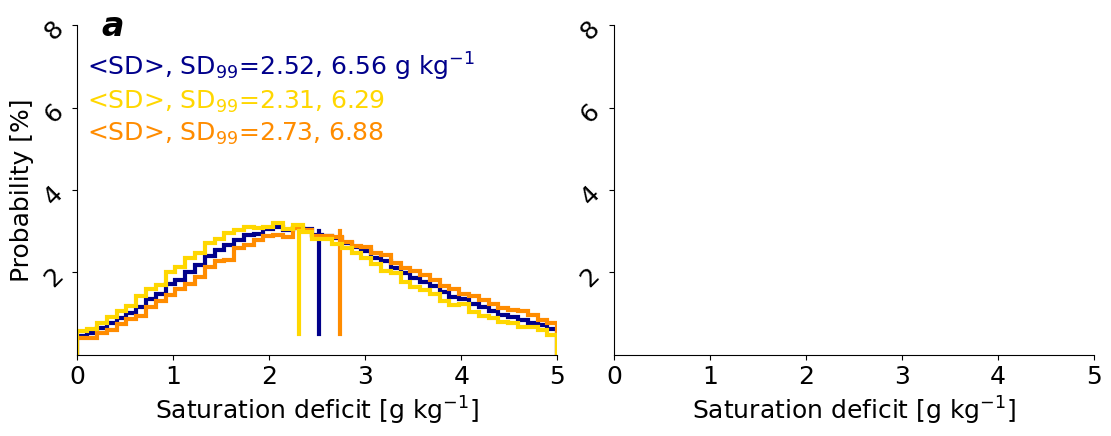

In [15]:
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(11,4.25), constrained_layout=True )
lw = 3
fs = 18
nbin = 50

wgts = np.ones_like(sd_ERAI)/float(len(sd_ERAI))*100.
ax[0].hist( sd_ERAI, bins=np.linspace(0,5,nbin), weights=wgts, histtype=u'step', lw=lw, color='darkblue' )
ax[0].plot( [np.nanmean(sd_ERAI), np.nanmean(sd_ERAI)], [0.5,3], lw=lw, color='darkblue' )
upp = np.percentile( rad_ERAI, 75 )
wgts = np.ones_like(sd_ERAI[rad_ERAI >= upp])/float(len(sd_ERAI[rad_ERAI >= upp]))*100.
ax[0].hist( sd_ERAI[rad_ERAI >= upp], bins=np.linspace(0,5,nbin), weights=wgts, histtype='step', lw=lw, color='darkorange' )
ax[0].plot( [np.nanmean(sd_ERAI[rad_ERAI >= upp]), np.nanmean(sd_ERAI[rad_ERAI >= upp])], [0.5,3], lw=lw, color='darkorange' )
loo = np.percentile( rad_ERAI, 25 )
wgts = np.ones_like(sd_ERAI[rad_ERAI <= loo])/float(len(sd_ERAI[rad_ERAI <= loo]))*100.
ax[0].hist( sd_ERAI[rad_ERAI <= loo], bins=np.linspace(0,5,nbin), weights=wgts, histtype='step', lw=lw, color='gold' )
ax[0].plot( [np.nanmean(sd_ERAI[rad_ERAI <= loo]), np.nanmean(sd_ERAI[rad_ERAI <= loo])], [0.5,3], lw=lw, color='gold' )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].text( 0.02, 0.85, r"<SD>, SD$_{99}$=" + f"{np.nanmean(sd_ERAI):.3}" + ', ' +
           f"{np.nanpercentile(sd_ERAI,99):.3}" + r' g kg$^{-1}$', color='darkblue', fontsize=fs, transform=ax[0].transAxes)
ax[0].text( 0.02, 0.75, r"<SD>, SD$_{99}$=" + f"{np.nanmean(sd_ERAI[rad_ERAI<=loo]):.3}" + ', ' +
           f"{np.nanpercentile(sd_ERAI[rad_ERAI<=loo],99):.3}" , color='gold', fontsize=fs, transform=ax[0].transAxes)
ax[0].text( 0.02, 0.65, r"<SD>, SD$_{99}$=" + f"{np.nanmean(sd_ERAI[rad_ERAI>=upp]):.3}" + ', ' +
           f"{np.nanpercentile(sd_ERAI[rad_ERAI>=upp],99):.3}", color='darkorange', fontsize=fs, transform=ax[0].transAxes)
#ax[0].set_xlim([10**(-3.5),1])
ax[0].text( 0.05, 0.97, 'a', weight='bold', style='italic', fontsize=fs+6, transform=ax[0].transAxes )

#wgts = np.ones_like(pmean_RCE)/float(len(pmean_RCE))*100.
#ax[1].hist( pmean_RCE, bins=np.logspace(-3,2,nbin), weights=wgts, lw=lw, color='darkblue', histtype=u'step' )
#ax[1].plot( [np.nanmean(pmean_RCE), np.nanmean(pmean_RCE)], [6,8], lw=lw, color='darkblue' )
#upp = np.percentile( rad_RCE, 75 )
#wgts = np.ones_like(pmean_RCE[rad_RCE >= upp])/float(len(pmean_RCE[rad_RCE >= upp]))*100.
#ax[1].hist( pmean_RCE[rad_RCE >= upp], bins=np.logspace(-3,2,nbin), lw=lw, color='darkorange', weights=wgts, histtype='step' )
#ax[1].plot( [np.nanmean(pmean_RCE[rad_RCE >= upp]), np.nanmean(pmean_RCE[rad_RCE >= upp])], [6,8], lw=lw, color='darkorange' )
#loo = np.percentile( rad_RCE, 25 )
#wgts = np.ones_like(pmean_RCE[rad_RCE <= loo])/float(len(pmean_RCE[rad_RCE <= loo]))*100.
#ax[1].hist( pmean_RCE[rad_RCE <= loo], bins=np.logspace(-3,2,nbin), weights=wgts, histtype='step', lw=lw, color='gold' )
#ax[1].text( 0.05, 0.97, 'b', weight='bold', style='italic', fontsize=fs+6, transform=ax[1].transAxes )
#ax[1].plot( [np.nanmean(pmean_RCE[rad_RCE <= loo]), np.nanmean(pmean_RCE[rad_RCE <= loo])], [6,8], lw=lw, color='gold' )
#ax[1].text( 0.02, 0.85, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE):.3}" + ", " +
#           f"{np.nanpercentile(pmean_RCE,99):.3}" + r' mm h$^{-1}$', color='darkblue', fontsize=fs, transform=ax[1].transAxes)
#ax[1].text( 0.02, 0.75, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE[rad_RCE<=loo]):.3}" + ", "
#           f"{np.nanpercentile(pmean_RCE[rad_RCE<=loo],99):.3}", color='gold', fontsize=fs, transform=ax[1].transAxes)
#ax[1].text( 0.02, 0.65, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE[rad_RCE>=upp]):.3}" + ", "
#           f"{np.nanpercentile(pmean_RCE[rad_RCE>=upp],99):.3}", color='darkorange', fontsize=fs, transform=ax[1].transAxes)
#ax[1].set_xscale( 'log' )

for a in ax:
    a.set_xlim([0,5])
    a.set_xlabel( r'Saturation deficit [g kg$^{-1}$]', fontsize=fs )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( 'both', labelsize=18 )
    a.tick_params( 'y', rotation=45 )
    #a.set_ylim([0,7])
    a.set_yticks( [2, 4, 6, 8] )
    
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precip-intensity-clustering.pdf', bbox_inches='tight' )
plt.show()